# Favorita Grocery Sales Forecasting

https://www.kaggle.com/c/favorita-grocery-sales-forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina' # High-resolution plot outputs for Retina laptops

In [2]:
# for Jupyter
from IPython.display import display

# for Fastai and PyTorch
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

# path to data
PATH='data/'

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Small:
# Checking some things

print(pd.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

0.22.0
True
True


In [4]:
!ls {PATH}

df_all_csv.feather	   oil.csv		  test.feather
df_missing_values.feather  oil.feather		  train.csv
holidays_events.csv	   sample_submission.csv  train.feather
holidays_events.feather    stores.csv		  transactions.csv
items.csv		   stores.feather	  transactions.feather
items.feather		   test.csv


# Functions

In [5]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None:
        right_on = left_on

    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [6]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


In [7]:
def mem_usage(df):
    sizes = list(df.memory_usage(deep=True) / 1024 ** 2)[1:]
    types = [t.name for t in df.dtypes]
    cols = list(df.columns)
    
    mem = pd.DataFrame({'columns': cols, 'size': sizes, 'type': types})
    
    return mem

In [8]:
def missing_values(df, print_flag=True):
    output = []
    for col in df.columns:
        a = len(df[col])
        b = len(df[df[col].isna()])
        if b != 0:
            if print_flag:
                print(f'For the "{col}" column, all records = {a}, with NA = {b}, good = {a-b}')
            else:
                output.append(col)
                
    return output

In [9]:
def count_by_value(df, col, value):
    return len(df.loc[df[col] == value])

In [10]:
def count_all_categories(df, col, num=5):
    cats = list(df[col].cat.categories)
    if len(cats) <= num:
        for cat in cats:
            print(f'"{cat}" has {count_by_value(df, col, cat)} records')
    else:
        print(f'The number of categories is {len(cats)}.')
        print(f'First {num} categories are: {cats[:num]}.')
        print(f'The category "Unknown" has {count_by_value(df, col, "Unknown")} records.')
        
    print(f'"NA" has {len(df[df[col].isna()])} records.')

In [11]:
def check_unknown(df, col, unknown):
    if unknown in list(df[col].cat.categories):
        unknown += '0'
        unknown = check_unknown(df, col, unknown)
    return unknown
            
def fill_na_categories(df):
    columns = missing_values(df, print_flag=False)
    for col in columns:
        if 'category' == str(df[col].dtype):
            unknown = check_unknown(df, col, 'Unknown')
            df[col].cat.add_categories(unknown, inplace=True)
            df[col] = df[col].fillna(unknown)
        print(f'In "{col}" NA\'s was filled by "{unknown}" value')
        
def fill_na_numerical(df, strategy='zero'):
    columns = missing_values(df, print_flag=False)
    for col in columns:
        if 'category' != str(df[col].dtype):
            unknown = 0
            df[col] = df[col].fillna(unknown)
        print(f'In "{col}" NA\'s was filled by "{unknown}" value')

In [12]:
def show_categories(df):
    for col in df.columns:
        if 'category' == str(df[col].dtype):
            print(f'The {color.BOLD}"{col}"{color.END} column has several categories')
            count_all_categories(df, col)
            print('\n')

# Examples

## How to use `join`

In [23]:
# Small Example to show how does the join_df function work

a = {'City Name': ['Tomsk', 'Omsk', 'Moscow'],
     'Value1': [1, 2, 3]}

b = {'Cities': ['Moscow', 'Tomsk', 'Omsk'],
     'Value2': ['q', 'w', 'e']}

a_df = pd.DataFrame(a)
b_df = pd.DataFrame(b)
c_df = join_df(a_df, b_df, "City Name", "Cities")

for t in [a_df, b_df, c_df]:
    display(t)

,City Name,Value1
0,Tomsk,1
1,Omsk,2
2,Moscow,3


,Cities,Value2
0,Moscow,q
1,Tomsk,w
2,Omsk,e


,City Name,Value1,Cities,Value2
0,Tomsk,1,Tomsk,w
1,Omsk,2,Omsk,e
2,Moscow,3,Moscow,q


# Read into Vars from Feather

In [13]:
# 0 - train
# 1 - holidat_events
# 2 - items
# 3 - oil
# 4 - stores
# 5 - transactions
# 6 - test


table_names = ['train', 'holidays_events', 'items', 'oil', 'stores', 'transactions', 'test']

tables = [pd.read_feather(f'{PATH}{fname}.feather') for fname in table_names]

In [14]:
train, holidays_events, items, oil, stores, transactions, test = tables

print((len(train), len(test)))

(125497040, 3370464)


In [15]:
display(len(tables))
display(type(tables))
display(type(tables[0]))

7

list

pandas.core.frame.DataFrame

## Memory Consumption

In [16]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
id             uint32
date           category
store_nbr      category
item_nbr       category
unit_sales     category
onpromotion    category
dtypes: category(5), uint32(1)
memory usage: 1.7 GB


In [17]:
holidays_events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
date           350 non-null category
type           350 non-null category
locale         350 non-null category
locale_name    350 non-null category
description    350 non-null category
transferred    350 non-null category
dtypes: category(6)
memory usage: 49.0 KB


In [18]:
items.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
item_nbr      4100 non-null category
family        4100 non-null category
class         4100 non-null category
perishable    4100 non-null category
dtypes: category(4)
memory usage: 472.7 KB


In [19]:
oil.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null category
dcoilwtico    1175 non-null float32
dtypes: category(1), float32(1)
memory usage: 126.9 KB


In [20]:
stores.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
store_nbr    54 non-null category
city         54 non-null category
state        54 non-null category
type         54 non-null category
cluster      54 non-null category
dtypes: category(5)
memory usage: 11.8 KB


In [21]:
transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
date            83488 non-null category
store_nbr       83488 non-null category
transactions    83488 non-null category
dtypes: category(3)
memory usage: 1.0 MB


# Join multiple CSV to one DF

In [ ]:
## Convert Date to Date type

**It does not need. Much effective to use feather files with categorical columns for date.**

In [21]:
# # 0 - train
# train['date'] = pd.to_datetime(train.date)

# # 1 - holidat_events
# holidays_events['date'] = pd.to_datetime(holidays_events.date)

# # 2 - items
# # It doesn't have the date field.

# # 3 - oil
# oil['date'] = pd.to_datetime(oil.date)

# # 4 - stores
# # It doesn't have the date field.

# # 5 - transactions
# transactions['date'] = pd.to_datetime(transactions.date)

# # 6 - test
# test['date'] = pd.to_datetime(test.date)

## Join Train and Stores

In [16]:
display(train.columns)
display(stores.columns)

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [17]:
df = join_df(train, stores, 'store_nbr', 'store_nbr')

In [18]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,25,103665,7.0,NaN,Puyo,Pastaza,C,7
1,1,2013-01-01,25,105574,1.0,NaN,Puyo,Pastaza,C,7
2,2,2013-01-01,25,105575,2.0,NaN,Puyo,Pastaza,C,7
3,3,2013-01-01,25,108079,1.0,NaN,Puyo,Pastaza,C,7
4,4,2013-01-01,25,108701,1.0,NaN,Puyo,Pastaza,C,7


In [19]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 10 columns):
id             uint32
date           category
store_nbr      category
item_nbr       category
unit_sales     category
onpromotion    category
city           category
state          category
type           category
cluster        category
dtypes: category(9), uint32(1)
memory usage: 3.1 GB


## Join DF and Holiday_Events, City

In [20]:
holidays_events.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [21]:
df = join_df(df, holidays_events, ['date', 'city'], ['date', 'locale_name'], suffix='_holiday')

In [22]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,type_holiday,locale,locale_name,description,transferred
0,0,2013-01-01,25,103665,7.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,25,105574,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,25,105575,2.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,25,108079,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,25,108701,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN


In [23]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125512042 entries, 0 to 125512041
Data columns (total 15 columns):
id              uint32
date            object
store_nbr       category
item_nbr        category
unit_sales      category
onpromotion     category
city            object
state           category
type            category
cluster         category
type_holiday    category
locale          category
locale_name     category
description     category
transferred     category
dtypes: category(12), object(2), uint32(1)
memory usage: 18.6 GB


In [24]:
df['date'] = df['date'].astype('category')
df['city'] = df['city'].astype('category')

In [25]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125512042 entries, 0 to 125512041
Data columns (total 15 columns):
id              uint32
date            category
store_nbr       category
item_nbr        category
unit_sales      category
onpromotion     category
city            category
state           category
type            category
cluster         category
type_holiday    category
locale          category
locale_name     category
description     category
transferred     category
dtypes: category(14), uint32(1)
memory usage: 3.6 GB


In [26]:
count_all_categories(df, 'type_holiday', 6)

"Additional" has 167729 records
"Bridge" has 0 records
"Event" has 0 records
"Holiday" has 362923 records
"Transfer" has 22222 records
"Work Day" has 0 records
"NA" has 124959168 records.


## Join DF and Holiday_Events, State

In [28]:
holidays_events.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [29]:
df = join_df(df, holidays_events, ['date', 'state'], ['date', 'locale_name'], suffix='_holiday')

In [30]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,typeholiday,locale,locale_name,description,transferred
0,0,2013-01-01,25,103665,7.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,25,105574,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,25,105575,2.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,25,108079,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,25,108701,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN


In [31]:
# DataFrameSummary(df).summary()

In [31]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 15 columns):
id             uint32
date           object
store_nbr      category
item_nbr       category
unit_sales     category
onpromotion    category
city           category
state          object
type           category
cluster        category
typeholiday    category
locale         category
locale_name    category
description    category
transferred    category
dtypes: category(12), object(2), uint32(1)
memory usage: 18.8 GB


In [32]:
mem_usage(df)

,columns,size,type
0,id,478.733215,uint32
1,date,8018.781357,object
2,store_nbr,119.688844,category
3,item_nbr,239.767878,category
4,unit_sales,504.360354,category
5,onpromotion,119.683497,category
6,city,119.685260,category
7,state,7899.702167,object
8,type,119.683771,category
9,cluster,119.684931,category


In [33]:
df['date'] = df.date.astype('category')
df['state'] = df.state.astype('category')

In [34]:
mem_usage(df)

,columns,size,type
0,id,478.733215,uint32
1,date,239.552334,category
2,store_nbr,119.688844,category
3,item_nbr,239.767878,category
4,unit_sales,504.360354,category
5,onpromotion,119.683497,category
6,city,119.685260,category
7,state,119.684922,category
8,type,119.683771,category
9,cluster,119.684931,category


In [35]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 15 columns):
id             uint32
date           category
store_nbr      category
item_nbr       category
unit_sales     category
onpromotion    category
city           category
state          category
type           category
cluster        category
typeholiday    category
locale         category
locale_name    category
description    category
transferred    category
dtypes: category(14), uint32(1)
memory usage: 3.6 GB


In [37]:
count_all_categories(df, 'typeholiday', 6)

"Additional" has 0 records
"Bridge" has 0 records
"Event" has 0 records
"Holiday" has 57200 records
"Transfer" has 0 records
"Work Day" has 0 records
"NA" has 125439840 records.


## Join DF and Items

In [37]:
display(items.columns)
display(df.columns)

Index(['item_nbr', 'family', 'class', 'perishable'], dtype='object')

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'city', 'state', 'type', 'cluster', 'type_y', 'locale', 'locale_name',
       'description', 'transferred'],
      dtype='object')

In [38]:
df = join_df(df, items, 'item_nbr', 'item_nbr')

In [39]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,type_y,locale,locale_name,description,transferred,family,class,perishable
0,0,2013-01-01,25,103665,7.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,BREAD/BAKERY,2712,1
1,1,2013-01-01,25,105574,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1045,0
2,2,2013-01-01,25,105575,2.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1045,0
3,3,2013-01-01,25,108079,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1030,0
4,4,2013-01-01,25,108701,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,DELI,2644,1


In [40]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 18 columns):
id             uint32
date           category
store_nbr      category
item_nbr       object
unit_sales     category
onpromotion    category
city           category
state          category
type           category
cluster        category
type_y         category
locale         category
locale_name    category
description    category
transferred    category
family         category
class          category
perishable     category
dtypes: category(16), object(1), uint32(1)
memory usage: 11.3 GB


In [41]:
df['item_nbr'] = df.item_nbr.astype('category')

In [42]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 18 columns):
id             uint32
date           category
store_nbr      category
item_nbr       category
unit_sales     category
onpromotion    category
city           category
state          category
type           category
cluster        category
type_y         category
locale         category
locale_name    category
description    category
transferred    category
family         category
class          category
perishable     category
dtypes: category(17), uint32(1)
memory usage: 4.1 GB


## Join DF and Oil

In [43]:
display(oil.columns)

Index(['date', 'dcoilwtico'], dtype='object')

In [44]:
df = join_df(df, oil, 'date', 'date')

In [45]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,type_y,locale,locale_name,description,transferred,family,class,perishable,dcoilwtico
0,0,2013-01-01,25,103665,7.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,BREAD/BAKERY,2712,1,NaN
1,1,2013-01-01,25,105574,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1045,0,NaN
2,2,2013-01-01,25,105575,2.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1045,0,NaN
3,3,2013-01-01,25,108079,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1030,0,NaN
4,4,2013-01-01,25,108701,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,DELI,2644,1,NaN


In [46]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 19 columns):
id             uint32
date           object
store_nbr      category
item_nbr       category
unit_sales     category
onpromotion    category
city           category
state          category
type           category
cluster        category
type_y         category
locale         category
locale_name    category
description    category
transferred    category
family         category
class          category
perishable     category
dcoilwtico     float32
dtypes: category(16), float32(1), object(1), uint32(1)
memory usage: 12.2 GB


In [47]:
df['date'] = df.date.astype('category')

In [48]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 19 columns):
id             uint32
date           category
store_nbr      category
item_nbr       category
unit_sales     category
onpromotion    category
city           category
state          category
type           category
cluster        category
type_y         category
locale         category
locale_name    category
description    category
transferred    category
family         category
class          category
perishable     category
dcoilwtico     float32
dtypes: category(17), float32(1), uint32(1)
memory usage: 4.6 GB


## Join DF and Transactions

In [49]:
display(transactions.columns)
display(df.columns)

Index(['date', 'store_nbr', 'transactions'], dtype='object')

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'city', 'state', 'type', 'cluster', 'type_y', 'locale', 'locale_name',
       'description', 'transferred', 'family', 'class', 'perishable',
       'dcoilwtico'],
      dtype='object')

In [50]:
df = join_df(df, transactions, ['date', 'store_nbr'], ['date', 'store_nbr'])

In [51]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 20 columns):
id              uint32
date            object
store_nbr       category
item_nbr        category
unit_sales      category
onpromotion     category
city            category
state           category
type            category
cluster         category
type_y          category
locale          category
locale_name     category
description     category
transferred     category
family          category
class           category
perishable      category
dcoilwtico      float32
transactions    category
dtypes: category(17), float32(1), object(1), uint32(1)
memory usage: 12.4 GB


In [52]:
df['date'] = df.date.astype('category')

In [53]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 20 columns):
id              uint32
date            category
store_nbr       category
item_nbr        category
unit_sales      category
onpromotion     category
city            category
state           category
type            category
cluster         category
type_y          category
locale          category
locale_name     category
description     category
transferred     category
family          category
class           category
perishable      category
dcoilwtico      float32
transactions    category
dtypes: category(18), float32(1), uint32(1)
memory usage: 4.8 GB


## View DF

In [54]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,type_y,locale,locale_name,description,transferred,family,class,perishable,dcoilwtico,transactions
0,0,2013-01-01,25,103665,7.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,BREAD/BAKERY,2712,1,NaN,NaN
1,1,2013-01-01,25,105574,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1045,0,NaN,NaN
2,2,2013-01-01,25,105575,2.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1045,0,NaN,NaN
3,3,2013-01-01,25,108079,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,GROCERY I,1030,0,NaN,NaN
4,4,2013-01-01,25,108701,1.0,NaN,Puyo,Pastaza,C,7,NaN,NaN,NaN,NaN,NaN,DELI,2644,1,NaN,NaN


In [55]:
# DataFrameSummary(df).summary()

## Save

In [56]:
df.to_feather(f'{PATH}df_all_csv.feather')

In [57]:
!ls -lh {PATH}

total 11G
-rw-r--r-- 1 paperspace paperspace 4.0G Sep 26 18:30 df_all_csv.feather
-rw-rw-r-- 1 paperspace paperspace  22K Oct 19  2017 holidays_events.csv
-rw-r--r-- 1 paperspace paperspace  11K Sep 26 14:23 holidays_events.feather
-rw-rw-r-- 1 paperspace paperspace 100K Oct 19  2017 items.csv
-rw-r--r-- 1 paperspace paperspace  71K Sep 26 14:23 items.feather
-rw-rw-r-- 1 paperspace paperspace  21K Oct 19  2017 oil.csv
-rw-r--r-- 1 paperspace paperspace  25K Sep 25 13:44 oil.feather
-rw-rw-r-- 1 paperspace paperspace  39M Oct 19  2017 sample_submission.csv
-rw-rw-r-- 1 paperspace paperspace 1.4K Oct 19  2017 stores.csv
-rw-r--r-- 1 paperspace paperspace 2.0K Sep 26 14:23 stores.feather
-rw-rw-r-- 1 paperspace paperspace 121M Oct 19  2017 test.csv
-rw-r--r-- 1 paperspace paperspace  29M Sep 26 14:23 test.feather
-rw-rw-r-- 1 paperspace paperspace 4.7G Oct 19  2017 train.csv
-rw-r--r-- 1 paperspace paperspace 1.7G Sep 26 14:23 train.feather
-rw-rw-r-- 1 paperspace paperspace 1.5M Oct 19 

In [58]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Read and Test

## Read from Feather

In [64]:
df = pd.read_feather(f'{PATH}df_all_csv.feather')

In [65]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 20 columns):
id              uint32
date            category
store_nbr       category
item_nbr        category
unit_sales      category
onpromotion     category
city            category
state           category
type            category
cluster         category
type_y          category
locale          category
locale_name     category
description     category
transferred     category
family          category
class           category
perishable      category
dcoilwtico      float32
transactions    category
dtypes: category(18), float32(1), uint32(1)
memory usage: 3.9 GB


In [ ]:
# DataFrameSummary(df).summary()

# Cases Which Should be Processed

Cases which should be processed in data:
* Missing values:
  * In categorical columns
  * In numerical columns. Some strategies: min, max, zero, mean (arithmetic, geometric), random, simple regression, neural network prediction.
  * In date and time columns
* Missing records:
  * If some days are missing


# Checking

Why after joining cvs files some categorical columns does not containt several categories?

For example: 
* `locale` column and `National` category
* `transferred` column and `True` category

# Missing Values

In [74]:
missing_values(df)

For the "onpromotion" column, all records = 125497040, with NA = 21657651, good = 103839389
For the "type_y" column, all records = 125497040, with NA = 125439840, good = 57200
For the "locale" column, all records = 125497040, with NA = 125439840, good = 57200
For the "locale_name" column, all records = 125497040, with NA = 125439840, good = 57200
For the "description" column, all records = 125497040, with NA = 125439840, good = 57200
For the "transferred" column, all records = 125497040, with NA = 125439840, good = 57200
For the "dcoilwtico" column, all records = 125497040, with NA = 40522930, good = 84974110
For the "transactions" column, all records = 125497040, with NA = 7347422, good = 118149618


[]

## `Onpromotion` Column

In [75]:
df.onpromotion.dtypes

CategoricalDtype(categories=['False', 'True'], ordered=False)

In [76]:
df.onpromotion.cat.add_categories('Unknown', inplace=True)
df['onpromotion'] = df.onpromotion.fillna('Unknown')

In [77]:
df.onpromotion.dtypes

CategoricalDtype(categories=['False', 'True', 'Unknown'], ordered=False)

In [78]:
count_all_categories(df, 'onpromotion')

"False" has 96028767 records
"True" has 7810622 records
"Unknown" has 21657651 records
"NA" has 0 records.


## Categorical Columns

In [79]:
fill_na_categories(df)

In "type_y" NA's was filled by "Unknown" value
In "locale" NA's was filled by "Unknown" value
In "locale_name" NA's was filled by "Unknown" value
In "description" NA's was filled by "Unknown" value
In "transferred" NA's was filled by "Unknown" value
In "dcoilwtico" NA's was filled by "0" value
In "transactions" NA's was filled by "Unknown" value


In [80]:
missing_values(df)

[]

## Numerical Columns

In [ ]:
fill_na_numerical(df)

In [ ]:
missing_values(df)

## Test

In [82]:
df.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'city', 'state', 'type', 'cluster', 'type_y', 'locale', 'locale_name',
       'description', 'transferred', 'family', 'class', 'perishable',
       'dcoilwtico', 'transactions'],
      dtype='object')

In [83]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 20 columns):
id              uint32
date            category
store_nbr       category
item_nbr        category
unit_sales      category
onpromotion     category
city            category
state           category
type            category
cluster         category
type_y          category
locale          category
locale_name     category
description     category
transferred     category
family          category
class           category
perishable      category
dcoilwtico      float32
transactions    category
dtypes: category(18), float32(1), uint32(1)
memory usage: 3.9 GB


In [84]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,type_y,locale,locale_name,description,transferred,family,class,perishable,dcoilwtico,transactions
0,0,2013-01-01,25,103665,7.0,Unknown,Puyo,Pastaza,C,7,Unknown,Unknown,Unknown,Unknown,Unknown,BREAD/BAKERY,2712,1,0.0,Unknown
1,1,2013-01-01,25,105574,1.0,Unknown,Puyo,Pastaza,C,7,Unknown,Unknown,Unknown,Unknown,Unknown,GROCERY I,1045,0,0.0,Unknown
2,2,2013-01-01,25,105575,2.0,Unknown,Puyo,Pastaza,C,7,Unknown,Unknown,Unknown,Unknown,Unknown,GROCERY I,1045,0,0.0,Unknown
3,3,2013-01-01,25,108079,1.0,Unknown,Puyo,Pastaza,C,7,Unknown,Unknown,Unknown,Unknown,Unknown,GROCERY I,1030,0,0.0,Unknown
4,4,2013-01-01,25,108701,1.0,Unknown,Puyo,Pastaza,C,7,Unknown,Unknown,Unknown,Unknown,Unknown,DELI,2644,1,0.0,Unknown


## Distribution

In [85]:
show_categories(df)

The "date" column has several categories
The number of categories is 1684.
First 5 categories are: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05'].
The category "Unknown" has 0 records.
"NA" has 0 records.


The "store_nbr" column has several categories
The number of categories is 54.
First 5 categories are: ['1', '10', '11', '12', '13'].
The category "Unknown" has 0 records.
"NA" has 0 records.


The "item_nbr" column has several categories
The number of categories is 4036.
First 5 categories are: ['1000866', '1001305', '1003679', '1004545', '1004550'].
The category "Unknown" has 0 records.
"NA" has 0 records.


The "unit_sales" column has several categories
The number of categories is 258474.
First 5 categories are: ['-1.0', '-19.0', '-2.0', '-27.0', '-3.0'].
The category "Unknown" has 0 records.
"NA" has 0 records.


The "onpromotion" column has several categories
"False" has 96028767 records
"True" has 7810622 records
"Unknown" has 21657651 records
"NA" has 0

## Save

In [86]:
df.to_feather(f'{PATH}df_missing_values.feather')

In [87]:
!ls -lh {PATH}

total 15G
-rw-r--r-- 1 paperspace paperspace 4.0G Sep 26 18:30 df_all_csv.feather
-rw-r--r-- 1 paperspace paperspace 3.9G Sep 26 18:40 df_missing_values.feather
-rw-rw-r-- 1 paperspace paperspace  22K Oct 19  2017 holidays_events.csv
-rw-r--r-- 1 paperspace paperspace  11K Sep 26 14:23 holidays_events.feather
-rw-rw-r-- 1 paperspace paperspace 100K Oct 19  2017 items.csv
-rw-r--r-- 1 paperspace paperspace  71K Sep 26 14:23 items.feather
-rw-rw-r-- 1 paperspace paperspace  21K Oct 19  2017 oil.csv
-rw-r--r-- 1 paperspace paperspace  25K Sep 25 13:44 oil.feather
-rw-rw-r-- 1 paperspace paperspace  39M Oct 19  2017 sample_submission.csv
-rw-rw-r-- 1 paperspace paperspace 1.4K Oct 19  2017 stores.csv
-rw-r--r-- 1 paperspace paperspace 2.0K Sep 26 14:23 stores.feather
-rw-rw-r-- 1 paperspace paperspace 121M Oct 19  2017 test.csv
-rw-r--r-- 1 paperspace paperspace  29M Sep 26 14:23 test.feather
-rw-rw-r-- 1 paperspace paperspace 4.7G Oct 19  2017 train.csv
-rw-r--r-- 1 paperspace paperspace 

# Visualize

## Read from Feather

In [4]:
df = pd.read_feather(f'{PATH}df_missing_values.feather') 

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 20 columns):
id              uint32
date            category
store_nbr       category
item_nbr        category
unit_sales      category
onpromotion     category
city            category
state           category
type            category
cluster         category
type_y          category
locale          category
locale_name     category
description     category
transferred     category
family          category
class           category
perishable      category
dcoilwtico      float32
transactions    category
dtypes: category(18), float32(1), uint32(1)
memory usage: 3.9 GB


## `date`, 1684

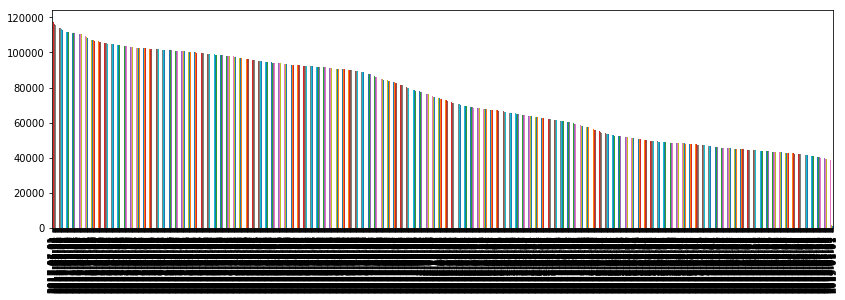

In [23]:
# plt.figure()
df['date'].value_counts().plot(kind='bar', figsize=(14, 4))

In [15]:
df['date'].value_counts()

2017-07-01    118194
2017-04-01    118122
2017-07-02    117286
2017-05-01    117116
2017-06-04    117074
2017-06-03    115996
2017-04-29    115862
2017-05-07    115664
2017-05-21    115144
2017-02-04    115084
2017-05-13    114607
2016-12-18    114252
2017-01-02    114225
2017-06-17    114148
2017-04-23    114009
2017-05-06    114004
2017-06-11    113990
2017-03-04    113770
2016-12-04    113721
2017-05-20    113494
2017-04-30    113415
2017-02-25    113068
2017-02-05    112794
2016-12-03    112701
2017-07-09    112589
2017-03-05    112532
2017-06-25    112383
2017-05-28    112291
2017-07-08    112051
2017-04-22    111981
               ...  
2013-01-16     40085
2013-01-21     40061
2013-02-21     40049
2013-01-04     40048
2013-01-31     40007
2013-01-25     39878
2013-01-30     39863
2013-02-12     39862
2013-01-18     39802
2013-01-28     39794
2013-02-10     39704
2013-01-15     39670
2013-03-14     39570
2013-01-23     39447
2013-01-29     39429
2013-01-22     39409
2013-01-14   

## `store_nbr`

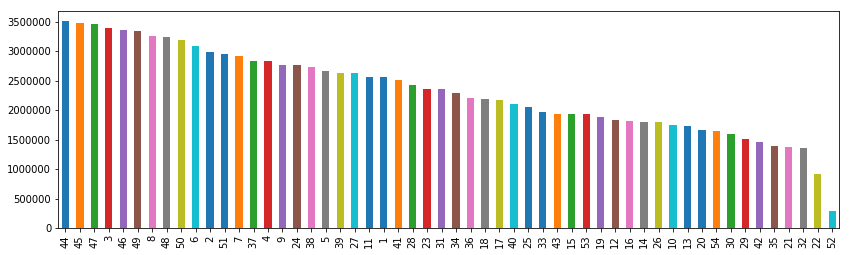

In [22]:
# plt.figure()
df['store_nbr'].value_counts().plot(kind='bar', figsize=(14, 4))

## `item_nbr`, 4036

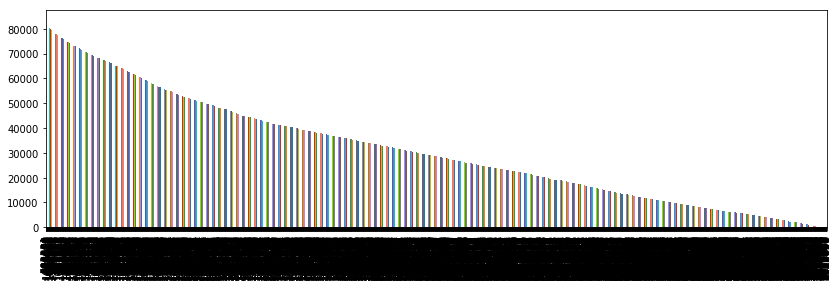

In [26]:
# plt.figure()
df['item_nbr'].value_counts().plot(kind='bar', figsize=(14, 4))

## `unit_sales`, 258 474

In [ ]:
# plt.figure()
df['unit_sales'].value_counts().plot(kind='bar', figsize=(14, 4))

## `onpromotion`

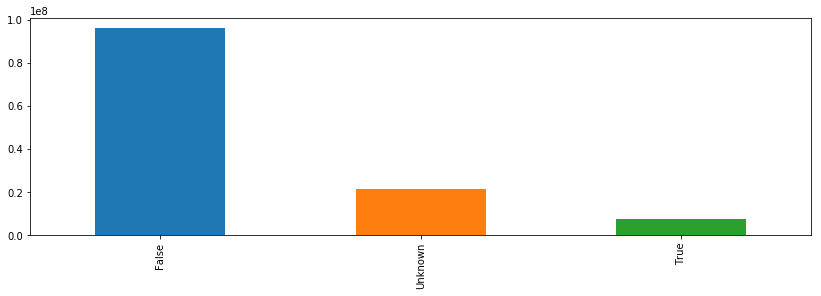

In [7]:
# plt.figure()
df['onpromotion'].value_counts().plot(kind='bar', figsize=(14, 4))

## `city`

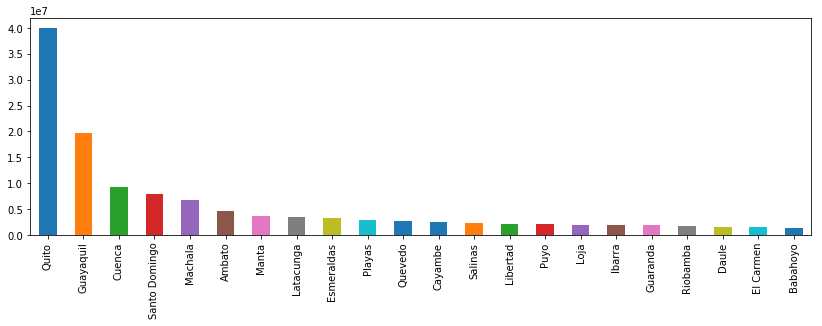

In [8]:
# plt.figure()
df['city'].value_counts().plot(kind='bar', figsize=(14, 4))

## `state`

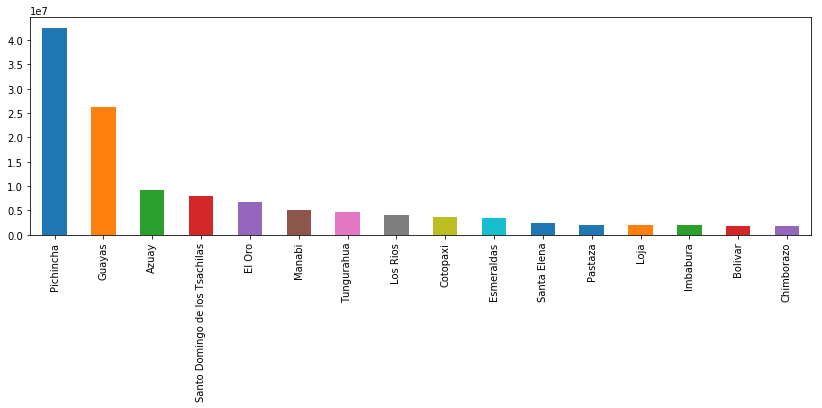

In [9]:
# plt.figure()
df['state'].value_counts().plot(kind='bar', figsize=(14, 4))

## `type`

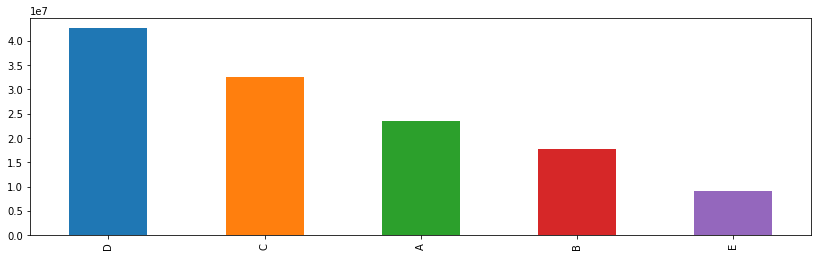

In [10]:
# plt.figure()
df['type'].value_counts().plot(kind='bar', figsize=(14, 4))

## `cluster`

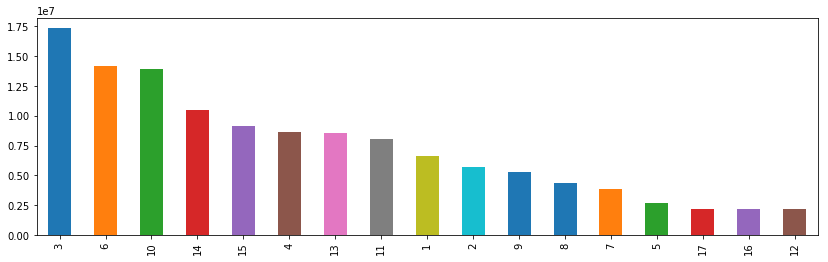

In [11]:
# plt.figure()
df['cluster'].value_counts().plot(kind='bar', figsize=(14, 4))

## `type_y` ?

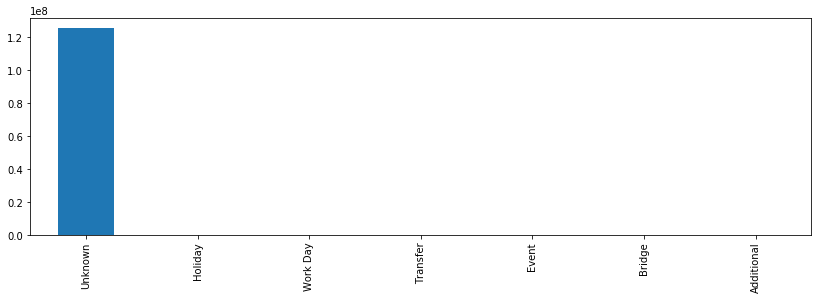

In [12]:
# plt.figure()
df['type_y'].value_counts().plot(kind='bar', figsize=(14, 4))

## `locale` ?

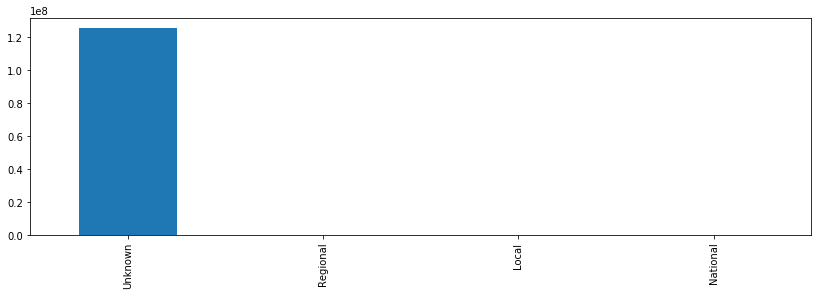

In [13]:
# plt.figure()
df['locale'].value_counts().plot(kind='bar', figsize=(14, 4))

## `locale_name` ?

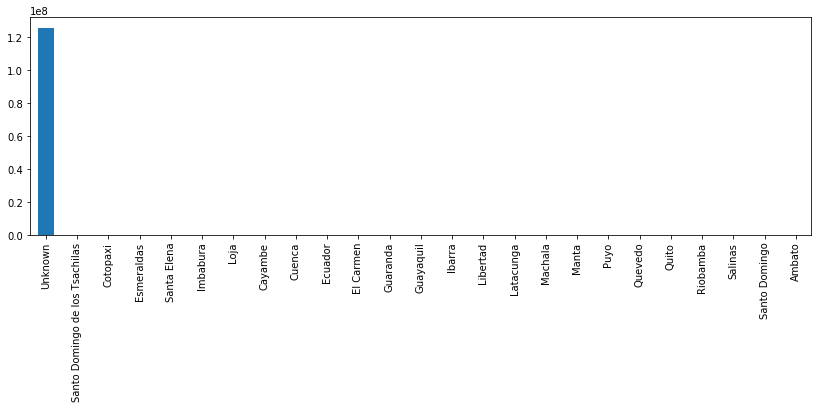

In [14]:
# plt.figure()
df['locale_name'].value_counts().plot(kind='bar', figsize=(14, 4))

## `description` ?

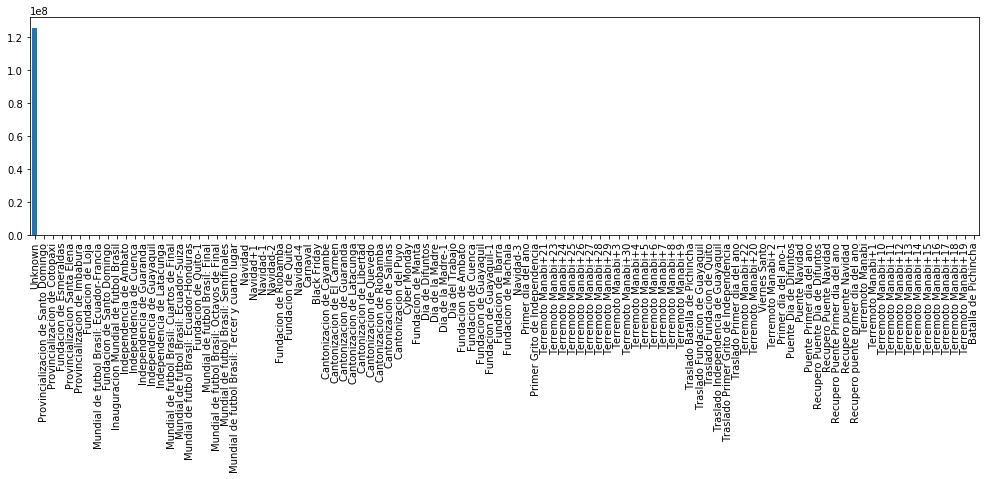

In [17]:
# plt.figure()
df['description'].value_counts().plot(kind='bar', figsize=(17, 4))

## `transferred` ?

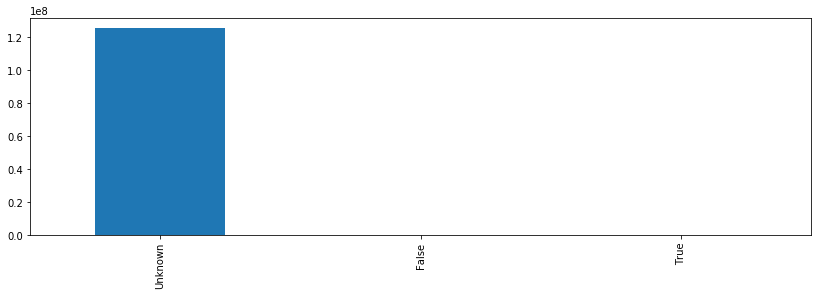

In [18]:
# plt.figure()
df['transferred'].value_counts().plot(kind='bar', figsize=(14, 4))

## `family`

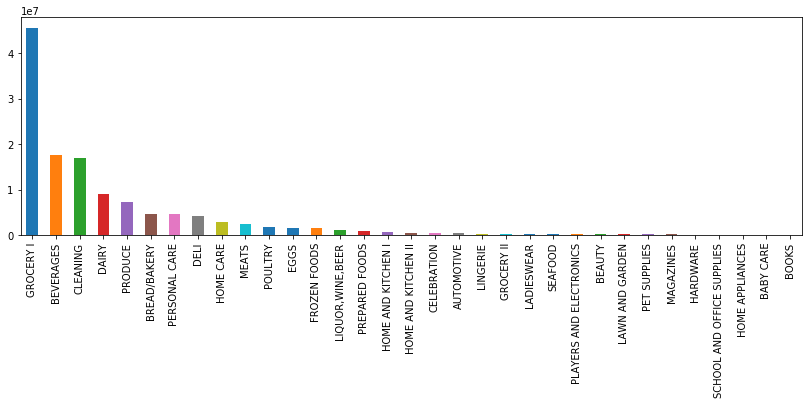

In [19]:
# plt.figure()
df['family'].value_counts().plot(kind='bar', figsize=(14, 4))

## `class`, 337

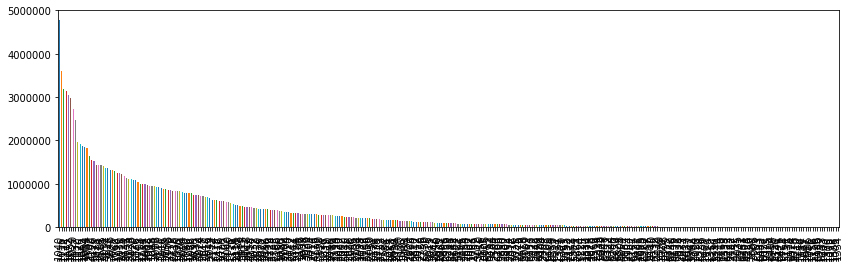

In [20]:
# plt.figure()
df['class'].value_counts().plot(kind='bar', figsize=(14, 4))

## `perishable`

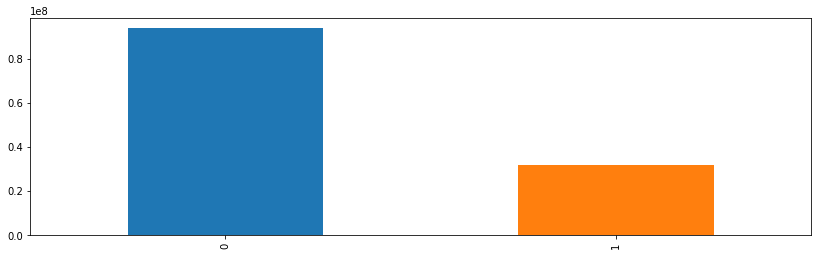

In [21]:
# plt.figure()
df['perishable'].value_counts().plot(kind='bar', figsize=(14, 4))

## `dcoilwtico`

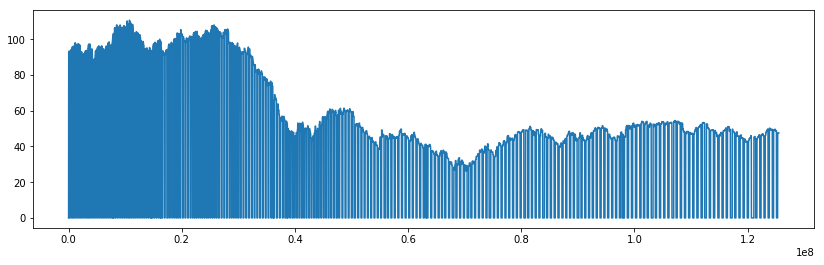

In [6]:
# plt.figure()
df['dcoilwtico'].plot(figsize=(14, 4))

## `transactions`, 4994

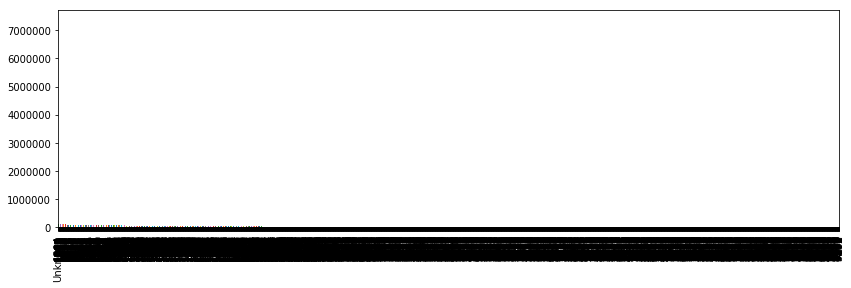

In [6]:
# plt.figure()
df['transactions'].value_counts().plot(kind='bar', figsize=(14, 4))

# Data cleaning / Feature Engineering